In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('../data/exams.csv')

# Encode categorical variables
label_encoders = {}
for column in ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Define features and target
X = data.drop(columns=['math score', 'reading score', 'writing score'])
y = data[['math score', 'reading score', 'writing score']].values

# Normalize the features
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

# Normalize the target variables
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y)

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)  # Increased dropout rate to 20%

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the neural network
input_size = X.shape[1]
output_size = y.shape[1]
model = NeuralNet(input_size, output_size)

# Group data by gender
males = data[data['gender'] == label_encoders['gender'].transform(['male'])[0]]
females = data[data['gender'] == label_encoders['gender'].transform(['female'])[0]]

# Get predictions for males and females
X_males = torch.tensor(scaler_X.transform(males.drop(columns=['math score', 'reading score', 'writing score'])), dtype=torch.float32)
y_males_pred = model(X_males).detach().numpy()

X_females = torch.tensor(scaler_X.transform(females.drop(columns=['math score', 'reading score', 'writing score'])), dtype=torch.float32)
y_females_pred = model(X_females).detach().numpy()

# Reverse normalization on predictions
y_males_pred_original = scaler_y.inverse_transform(y_males_pred)
y_females_pred_original = scaler_y.inverse_transform(y_females_pred)

# Calculate residuals (difference between actual and predicted scores)
residuals_males = males[['math score', 'reading score', 'writing score']].values - y_males_pred_original
residuals_females = females[['math score', 'reading score', 'writing score']].values - y_females_pred_original

# Create DataFrame for plotting gender analysis
gender_plot_data = pd.DataFrame({
    'gender': ['male'] * len(y_males_pred) + ['female'] * len(y_females_pred),
    'predicted_math_score': list(y_males_pred_original[:, 0]) + list(y_females_pred_original[:, 0]),
    'predicted_reading_score': list(y_males_pred_original[:, 1]) + list(y_females_pred_original[:, 1]),
    'predicted_writing_score': list(y_males_pred_original[:, 2]) + list(y_females_pred_original[:, 2]),
    'residual_math_score': list(residuals_males[:, 0]) + list(residuals_females[:, 0]),
    'residual_reading_score': list(residuals_males[:, 1]) + list(residuals_females[:, 1]),
    'residual_writing_score': list(residuals_males[:, 2]) + list(residuals_females[:, 2])
})




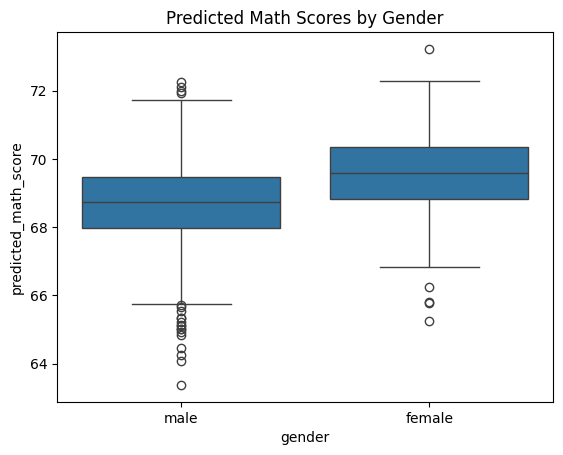

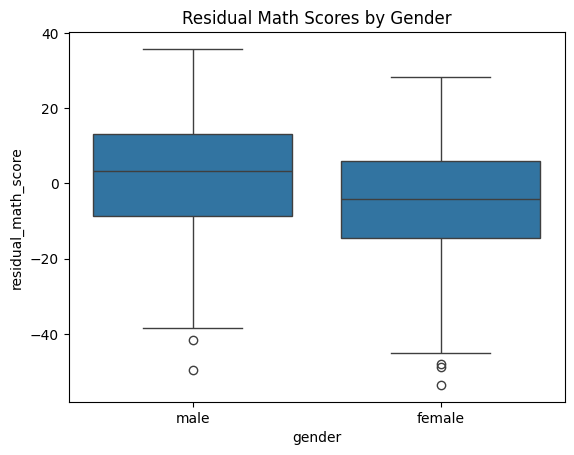

In [2]:
sns.boxplot(x='gender', y='predicted_math_score', data=gender_plot_data)
plt.title('Predicted Math Scores by Gender')
plt.show()

sns.boxplot(x='gender', y='residual_math_score', data=gender_plot_data)
plt.title('Residual Math Scores by Gender')
plt.show()

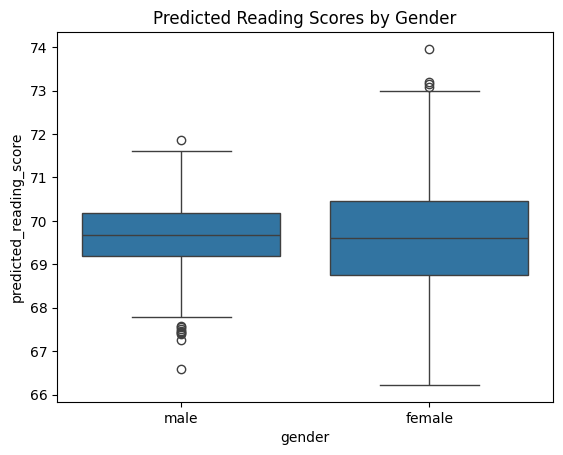

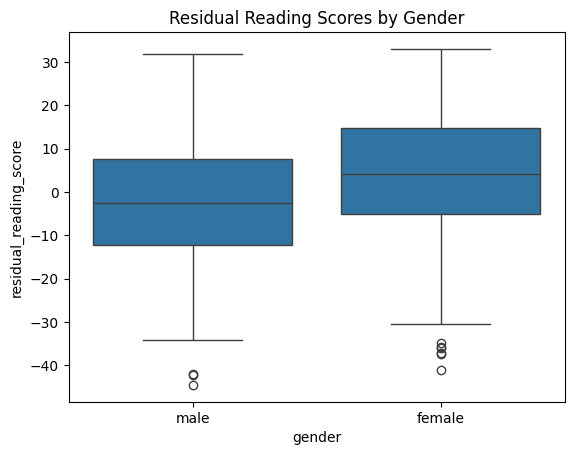

In [3]:
sns.boxplot(x='gender', y='predicted_reading_score', data=gender_plot_data)
plt.title('Predicted Reading Scores by Gender')
plt.show()

sns.boxplot(x='gender', y='residual_reading_score', data=gender_plot_data)
plt.title('Residual Reading Scores by Gender')
plt.show()

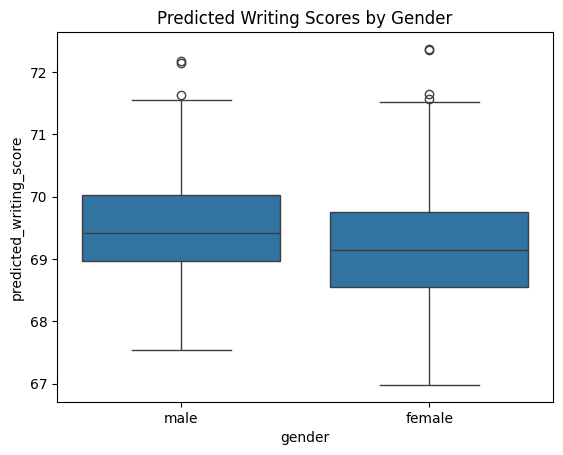

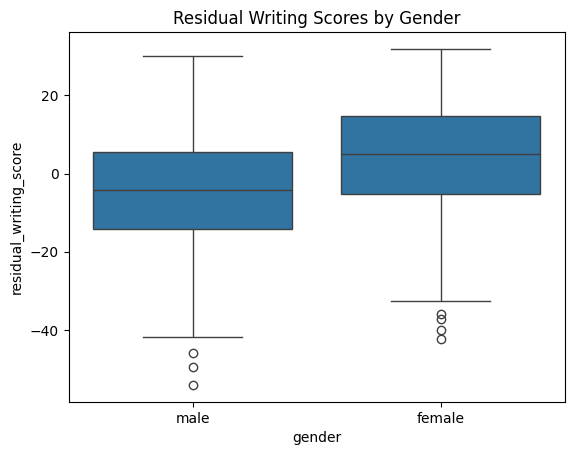

In [4]:
sns.boxplot(x='gender', y='predicted_writing_score', data=gender_plot_data)
plt.title('Predicted Writing Scores by Gender')
plt.show()


sns.boxplot(x='gender', y='residual_writing_score', data=gender_plot_data)
plt.title('Residual Writing Scores by Gender')
plt.show()

In [6]:
# Group data by ethnicity
ethnicities = data['race/ethnicity'].unique()

# Initialize lists to store the data for ethnicity plotting
predicted_reading_scores = []
predicted_writing_scores = []
residual_reading_scores = []
residual_writing_scores = []
ethnicity_labels = []

# Loop over each ethnicity group and make predictions
for ethnicity in ethnicities:
    group_data = data[data['race/ethnicity'] == ethnicity]
    
    X_group = torch.tensor(scaler_X.transform(group_data.drop(columns=['math score', 'reading score', 'writing score'])), dtype=torch.float32)
    y_group_actual = group_data[['math score', 'reading score', 'writing score']].values
    
    # Predict the scores
    y_group_pred = model(X_group).detach().numpy()
    
    # Reverse normalization on predictions
    y_group_pred_original = scaler_y.inverse_transform(y_group_pred)
    
    # Calculate residuals
    residuals = y_group_actual - y_group_pred_original


    
    # Store the results for plotting
    predicted_reading_scores.extend(y_group_pred_original[:, 1])
    predicted_writing_scores.extend(y_group_pred_original[:, 2])
    residual_reading_scores.extend(residuals[:, 1])
    residual_writing_scores.extend(residuals[:, 2])
    ethnicity_labels.extend([ethnicity] * len(y_group_pred_original))

# Create DataFrame for plotting ethnicity analysis
ethnicity_plot_data = pd.DataFrame({
    'predicted_reading_score': predicted_reading_scores,
    'predicted_writing_score': predicted_writing_scores,
    'residual_reading_score': residual_reading_scores,
    'residual_writing_score': residual_writing_scores,
    'race/ethnicity': ethnicity_labels
})


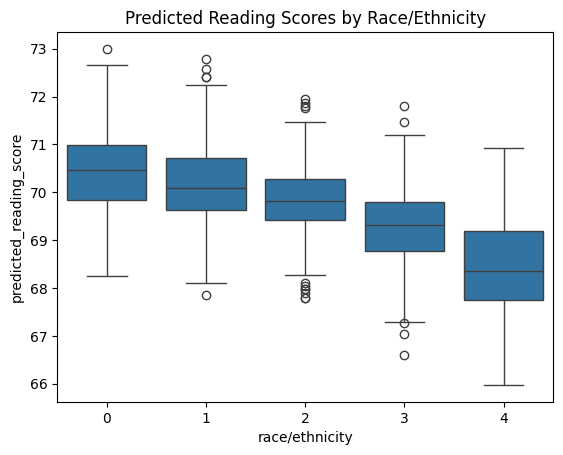

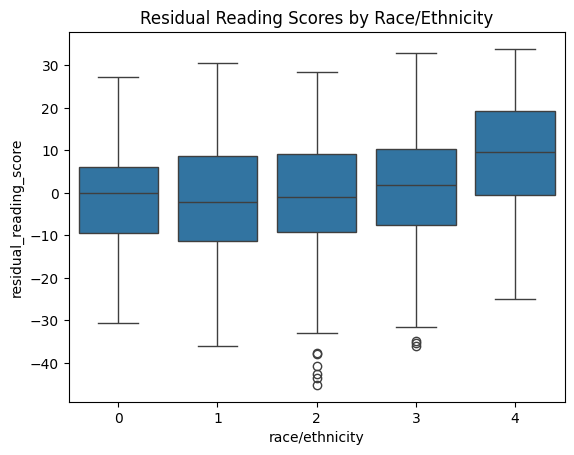

In [7]:
# Plot predicted reading scores by race/ethnicity
sns.boxplot(x='race/ethnicity', y='predicted_reading_score', data=ethnicity_plot_data)
plt.title('Predicted Reading Scores by Race/Ethnicity')
plt.show()

# Plot residual reading scores by race/ethnicity
sns.boxplot(x='race/ethnicity', y='residual_reading_score', data=ethnicity_plot_data)
plt.title('Residual Reading Scores by Race/Ethnicity')
plt.show()


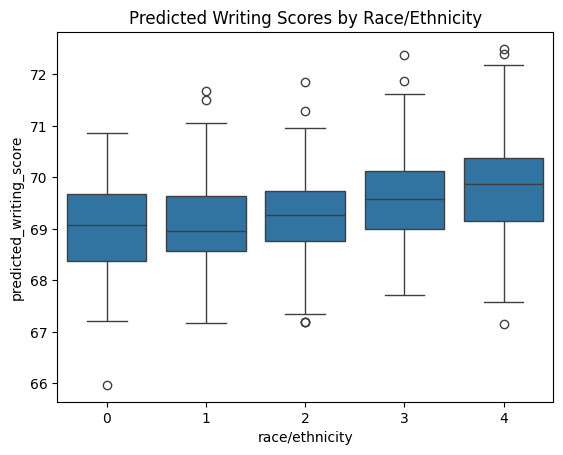

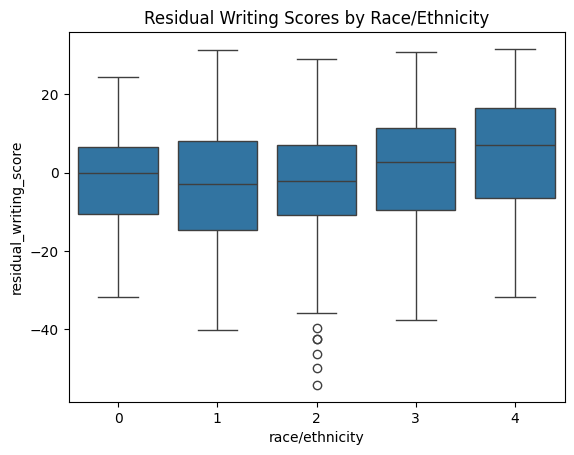

In [8]:
# Plot predicted writing scores by race/ethnicity
sns.boxplot(x='race/ethnicity', y='predicted_writing_score', data=ethnicity_plot_data)
plt.title('Predicted Writing Scores by Race/Ethnicity')
plt.show()

# Plot residual writing scores by race/ethnicity
sns.boxplot(x='race/ethnicity', y='residual_writing_score', data=ethnicity_plot_data)
plt.title('Residual Writing Scores by Race/Ethnicity')
plt.show()

In [9]:
# Group data by parental level of education
education_levels = data['parental level of education'].unique()

# Initialize lists to store the data for parental level of education plotting
predicted_reading_scores_education = []
predicted_writing_scores_education = []
residual_reading_scores_education = []
residual_writing_scores_education = []
education_labels = []

# Loop over each parental level of education group and make predictions
for education_level in education_levels:
    group_data = data[data['parental level of education'] == education_level]
    
    X_group = torch.tensor(scaler_X.transform(group_data.drop(columns=['math score', 'reading score', 'writing score'])), dtype=torch.float32)
    y_group_actual = group_data[['math score', 'reading score', 'writing score']].values
    
    # Predict the scores
    y_group_pred = model(X_group).detach().numpy()
    
    # Reverse normalization on predictions
    y_group_pred_original = scaler_y.inverse_transform(y_group_pred)
    
    # Calculate residuals
    residuals = y_group_actual - y_group_pred_original
    
    # Store the results for plotting
    predicted_reading_scores_education.extend(y_group_pred_original[:, 1])
    predicted_writing_scores_education.extend(y_group_pred_original[:, 2])
    residual_reading_scores_education.extend(residuals[:, 1])
    residual_writing_scores_education.extend(residuals[:, 2])
    education_labels.extend([education_level] * len(y_group_pred_original))

# Create DataFrame for plotting parental level of education analysis
education_plot_data = pd.DataFrame({
    'predicted_reading_score': predicted_reading_scores_education,
    'predicted_writing_score': predicted_writing_scores_education,
    'residual_reading_score': residual_reading_scores_education,
    'residual_writing_score': residual_writing_scores_education,
    'parental level of education': education_labels
})

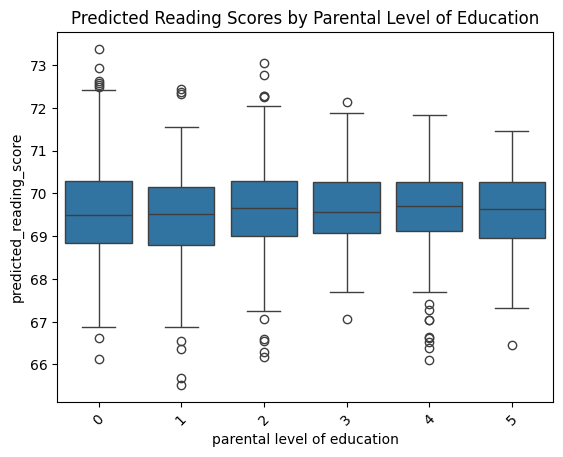

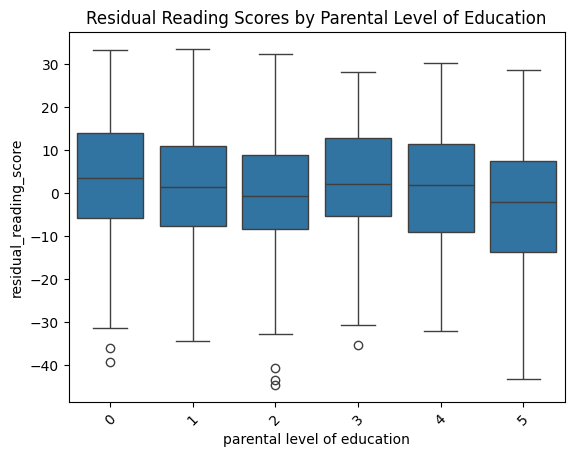

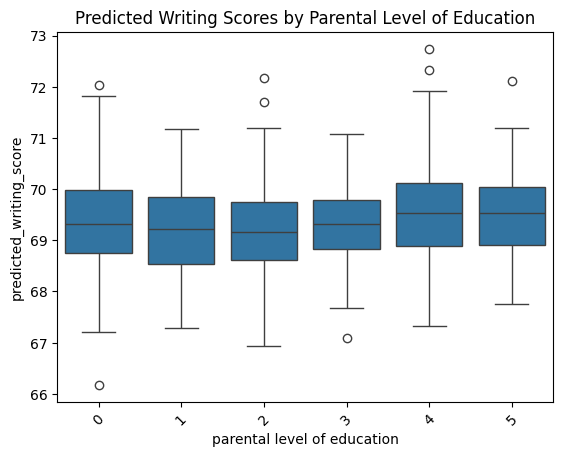

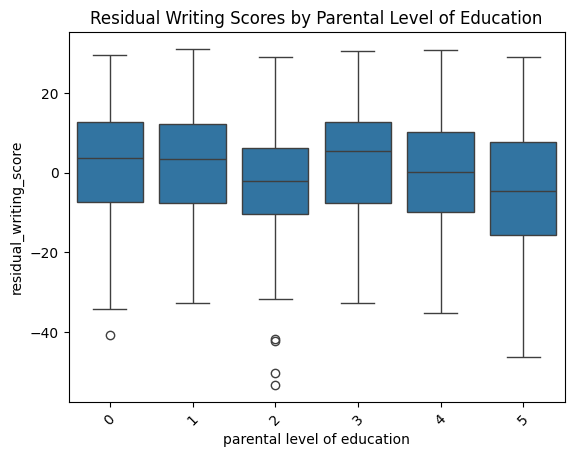

In [10]:

# Plot predicted reading scores by parental level of education
sns.boxplot(x='parental level of education', y='predicted_reading_score', data=education_plot_data)
plt.title('Predicted Reading Scores by Parental Level of Education')
plt.xticks(rotation=45)
plt.show()

# Plot residual reading scores by parental level of education
sns.boxplot(x='parental level of education', y='residual_reading_score', data=education_plot_data)
plt.title('Residual Reading Scores by Parental Level of Education')
plt.xticks(rotation=45)
plt.show()

# Plot predicted writing scores by parental level of education
sns.boxplot(x='parental level of education', y='predicted_writing_score', data=education_plot_data)
plt.title('Predicted Writing Scores by Parental Level of Education')
plt.xticks(rotation=45)
plt.show()

# Plot residual writing scores by parental level of education
sns.boxplot(x='parental level of education', y='residual_writing_score', data=education_plot_data)
plt.title('Residual Writing Scores by Parental Level of Education')
plt.xticks(rotation=45)
plt.show()
